### The German Traffic Sign Benchmark

Download full data set from http://benchmark.ini.rub.de/?section=gtsdb&subsection=dataset

In [1]:
# !wget -c http://benchmark.ini.rub.de/Dataset_GTSDB/FullIJCNN2013.zip
# !unzip FullIJCNN2013.zip

In [1]:
import numpy as np
import cv2

IMG_HEIGHT = 600
SIGN_SIZE = (112, 112)

# Function for reading the images
def readImages(rootpath, images_range, signs_range):
    '''Reads traffic sign data for German Traffic Sign Recognition Benchmark.
    Arguments: path to the traffic sign data, for example 'FullIJCNN2013'
    Returns:   list of images, list of corresponding labels'''
    images = {} # original image
    scales = {} # original scale
    for num in images_range:
        filename = rootpath + '/' + "{:05d}".format(num) + '.ppm'
        img = cv2.imread(filename, cv2.IMREAD_COLOR)
        scale = IMG_HEIGHT / float(img.shape[0])
        img_resized = cv2.resize(img, (int(img.shape[1]*scale),int(img.shape[0]*scale)))
        images.setdefault(filename,[]).append(img_resized)
        scales.setdefault(filename,[]).append(scale)

    files = [] # filenames
    signs = [] # traffic sign image
    bboxes = [] # corresponding box detection
    labels = [] # traffic sign type
    data = np.genfromtxt(rootpath + '/' + 'gt.txt', delimiter=';', dtype=str, usecols=range(0, 6))
    for elem in signs_range:
        filename = rootpath + '/' + data[elem][0]
        img = images.get(filename)[0]
        scale = scales.get(filename)[0]
        bbox = np.array([int(data[elem][1]), int(data[elem][2]), int(data[elem][3]), int(data[elem][4])]) * scale
        sign = img[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        sign_resized = cv2.resize(sign, SIGN_SIZE)
        files.append(filename)
        signs.append(sign_resized)
        bboxes.append(bbox)
        labels.append(data[elem][5])
    return images, files, signs, bboxes, labels

In [2]:
# The German Traffic Sign Recognition Benchmark
train_images, train_files, train_signs, train_bboxes, train_labels = readImages('FullIJCNN2013', range(0,600), range(0,852))
test_images, test_files, test_signs, test_bboxes, test_labels = readImages('FullIJCNN2013', range(600,900), range(852,1213))

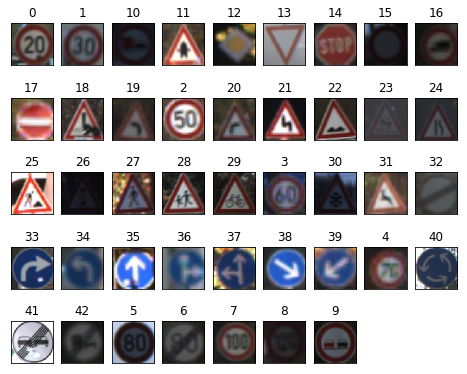

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Show examples from each class
class_names = np.unique(train_labels)
num_classes = len(class_names)
fig = plt.figure(figsize=(8,8))
for i in range(num_classes):
    ax = fig.add_subplot(6, 9, 1 + i, xticks=[], yticks=[])
    ax.set_title(class_names[i])
    indices = np.where(np.isin(train_labels, class_names[i]))[0]
    plt.imshow(cv2.cvtColor(train_signs[int(np.random.choice(indices, 1))], cv2.COLOR_BGR2RGB))
plt.show()

In [4]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
import tensorflow as tf

# tf.get_default_session().close()
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
session.as_default()

from sklearn.utils import shuffle
train_files, train_signs, train_bboxes, train_labels = shuffle(train_files, train_signs, train_bboxes, train_labels)
# plt.imshow(cv2.cvtColor(train_images.get(train_files[0])[0], cv2.COLOR_BGR2RGB))
# plt.show()
# plt.imshow(cv2.cvtColor(train_signs[0], cv2.COLOR_BGR2RGB))
# plt.show()
# print(train_bboxes[0])
# print(train_labels[0])

# Data pre-processing
tr_signs = np.array(train_signs)[0:600]
tr_labels = np.array(train_labels)[0:600]
va_signs = np.array(train_signs)[600:852]
va_labels = np.array(train_labels)[600:852]
te_signs = np.array(test_signs)
te_labels = np.array(test_labels)

tr_signs = tr_signs.astype('float32')
va_signs = va_signs.astype('float32')
te_signs = te_signs.astype('float32')
tr_signs /= 255.0
va_signs /= 255.0
te_signs /= 255.0

from keras.utils import np_utils
tr_labels = np_utils.to_categorical(tr_labels, num_classes)
va_labels = np_utils.to_categorical(va_labels, num_classes)
te_labels = np_utils.to_categorical(te_labels, num_classes)

Using TensorFlow backend.


In [5]:
# Tensorboard
from time import time
from keras.callbacks import TensorBoard
tensorboard = TensorBoard(log_dir='logs/{}'.format(time()))

## Assignment 3.4: Traffic sign detection

sudo pip install Keras==2.1.6

In [6]:
ANCHOR_RATIOS = (0.5, 1.0, 2.0)
ANCHOR_STRIDE = 16
ANCHOR_SIZES = (32, 64, 128, 256, 512)
MAX_SIZE = 1344
MIN_SIZE = 0

# Parameters to play with to modify the number of proposal in each image
TEST_PRE_NMS_TOPK = 50000 # The maximum number of positive samples taken during proposal generation, pre NMS
TEST_POST_NMS_TOPK = 5000 # The maximum number of positive samples taken during proposal generation, post NMS
PROPOSAL_NMS_THRESH = 0.9

In [7]:
"""Operations for [N, 4] numpy arrays representing bounding boxes.
Example box operations that are supported:
  * Areas: compute bounding box areas
  * IOU: pairwise intersection-over-union scores
"""
def area(boxes):
    """Computes area of boxes.
    Args:
    boxes: Numpy array with shape [N, 4] holding N boxes
    Returns:
    a numpy array with shape [N*1] representing box areas
    """
    return (boxes[:, 2] - boxes[:, 0]) * (boxes[:, 3] - boxes[:, 1])

def intersection(boxes1, boxes2):
    """Compute pairwise intersection areas between boxes.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes
    boxes2: a numpy array with shape [M, 4] holding M boxes
    Returns:
    a numpy array with shape [N*M] representing pairwise intersection area
    """
    [x_min1, y_min1, x_max1, y_max1] = np.split(boxes1, 4, axis=1)
    [x_min2, y_min2, x_max2, y_max2] = np.split(boxes2, 4, axis=1)
    all_pairs_min_ymax = np.minimum(y_max1, np.transpose(y_max2))
    all_pairs_max_ymin = np.maximum(y_min1, np.transpose(y_min2))
    intersect_heights = np.maximum(np.zeros(all_pairs_max_ymin.shape, dtype='f4'),all_pairs_min_ymax - all_pairs_max_ymin)
    all_pairs_min_xmax = np.minimum(x_max1, np.transpose(x_max2))
    all_pairs_max_xmin = np.maximum(x_min1, np.transpose(x_min2))
    intersect_widths = np.maximum(np.zeros(all_pairs_max_xmin.shape, dtype='f4'),all_pairs_min_xmax - all_pairs_max_xmin)
    return intersect_heights * intersect_widths

def iou(boxes1, boxes2):
    """Computes pairwise intersection-over-union between box collections.
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding M boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise iou scores.
    """
    intersect = intersection(boxes1, boxes2)
    area1 = area(boxes1)
    area2 = area(boxes2)
    union = np.expand_dims(area1, axis=1) + np.expand_dims(area2, axis=0) - intersect
    return intersect / union

def ioa(boxes1, boxes2):
    """Computes pairwise intersection-over-area between box collections.
    Intersection-over-area (ioa) between two boxes box1 and box2 is defined as
    their intersection area over box2's area. Note that ioa is not symmetric,
    that is, IOA(box1, box2) != IOA(box2, box1).
    Args:
    boxes1: a numpy array with shape [N, 4] holding N boxes.
    boxes2: a numpy array with shape [M, 4] holding N boxes.
    Returns:
    a numpy array with shape [N, M] representing pairwise ioa scores.
    """
    intersect = intersection(boxes1, boxes2)
    inv_areas = np.expand_dims(1.0 / area(boxes2), axis=0)
    return intersect * inv_areas

def clip_boxes(bboxes, clip_box, alpha):
    """
    This function clip the bboxes to the border of the image

    :param bboxes: array of shape (Nx4) containing the coordinates of the bboxes
                in the format: xmin, ymin, xmax, ymax.
    :param clip_box: array of shape (4,) containing the coordinates of the image
                in the format: xmin, ymin, xmax ymax.
    :param alpha:float, minimum threshold of area acepted. If a clipped bbpx
                    have an relative area (wrt their original area) less than
                    alpha, it is discarded.
    :return: numpy array Nx4 of the clipped bboxes with their new coordinates
            in the format xmin, ymin, xmax, ymax.
    """
    areas = area(bboxes)
    bboxes[:, 0] = np.maximum(bboxes[:, 0], clip_box[0])
    bboxes[:, 1] = np.maximum(bboxes[:, 1], clip_box[1])
    bboxes[:, 2] = np.minimum(bboxes[:, 2], clip_box[2])
    bboxes[:, 3] = np.minimum(bboxes[:, 3], clip_box[3])
    new_areas = area(bboxes)
    delta_area = (areas - new_areas) / areas
    mask = np.where(delta_area < 1 - alpha)
    bboxes = bboxes[mask[0]]
    return bboxes

In [8]:
import tensorflow as tf

def generate_anchors(base_size=16, ratios=[0.5, 1, 2], scales=2**np.arange(3, 6)):
    """
    Generate anchor (reference) windows by enumerating aspect ratios X
    scales wrt a reference (0, 0, 15, 15) window.
    """
    base_anchor = np.array([1, 1, base_size, base_size], dtype='float32') - 1
    ratio_anchors = _ratio_enum(base_anchor, ratios)
    anchors = np.vstack([_scale_enum(ratio_anchors[i, :], scales) for i in range(ratio_anchors.shape[0])])
    return anchors

def _whctrs(anchor):
    """
    Return width, height, x center, and y center for an anchor (window).
    """
    w = anchor[2] - anchor[0] + 1
    h = anchor[3] - anchor[1] + 1
    x_ctr = anchor[0] + 0.5 * (w - 1)
    y_ctr = anchor[1] + 0.5 * (h - 1)
    return w, h, x_ctr, y_ctr

def _mkanchors(ws, hs, x_ctr, y_ctr):
    """
    Given a vector of widths (ws) and heights (hs) around a center
    (x_ctr, y_ctr), output a set of anchors (windows).
    """
    ws = ws[:, np.newaxis]
    hs = hs[:, np.newaxis]
    anchors = np.hstack((x_ctr - 0.5 * (ws - 1), y_ctr - 0.5 * (hs - 1), x_ctr + 0.5 * (ws - 1), y_ctr + 0.5 * (hs - 1)))
    return anchors

def _ratio_enum(anchor, ratios):
    """
    Enumerate a set of anchors for each aspect ratio wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    size = w * h
    size_ratios = size / ratios
    ws = np.round(np.sqrt(size_ratios))
    hs = np.round(ws * ratios)
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def _scale_enum(anchor, scales):
    """
    Enumerate a set of anchors for each scale wrt an anchor.
    """
    w, h, x_ctr, y_ctr = _whctrs(anchor)
    ws = w * scales
    hs = h * scales
    anchors = _mkanchors(ws, hs, x_ctr, y_ctr)
    return anchors

def get_all_anchors(stride=None, sizes=None):
    """
    Get all anchors in the largest possible image, shifted, floatbox
    Args:
        stride (int): the stride of anchors.
        sizes (tuple[int]): the sizes (sqrt area) of anchors

    Returns:
        anchors: SxSxNUM_ANCHORx4, where S == ceil(MAX_SIZE/STRIDE), floatbox
        The layout in the NUM_ANCHOR dim is NUM_RATIO x NUM_SIZE.

    """
    if stride is None:
        stride = ANCHOR_STRIDE
    if sizes is None:
        sizes = ANCHOR_SIZES
    # Generates a NAx4 matrix of anchor boxes in (x1, y1, x2, y2) format. Anchors
    # are centered on stride / 2, have (approximate) sqrt areas of the specified
    # sizes, and aspect ratios as given.
    cell_anchors = generate_anchors(stride, scales=np.array(sizes, dtype=np.float) / stride, ratios=np.array(ANCHOR_RATIOS, dtype=np.float))
    # anchors are intbox here.
    # anchors at featuremap [0,0] are centered at fpcoor (8,8) (half of stride)
    field_size = int(np.ceil(MAX_SIZE / stride))
    shifts = np.arange(0, field_size) * stride
    shift_x, shift_y = np.meshgrid(shifts, shifts)
    shift_x = shift_x.flatten()
    shift_y = shift_y.flatten()
    shifts = np.vstack((shift_x, shift_y, shift_x, shift_y)).transpose()
    K = shifts.shape[0]

    A = cell_anchors.shape[0]
    field_of_anchors = (
        cell_anchors.reshape((1, A, 4)) +
        shifts.reshape((1, K, 4)).transpose((1, 0, 2)))
    field_of_anchors = field_of_anchors.reshape((field_size, field_size, A, 4))
    field_of_anchors = field_of_anchors.astype('float32')
    field_of_anchors[:, :, :, [2, 3]] += 1
    return field_of_anchors

def decode_bbox_target(box_predictions, anchors):
    """
    Args:
        box_predictions: (..., 4), logits
        anchors: (..., 4), floatbox. Must have the same shape

    Returns:
        box_decoded: (..., 4), float32. With the same shape.
    """
    orig_shape = tf.shape(anchors)
    box_pred_txtytwth = tf.reshape(box_predictions, (-1, 2, 2))
    box_pred_txty, box_pred_twth = tf.split(box_pred_txtytwth, 2, axis=1)
    anchors_x1y1x2y2 = tf.reshape(anchors, (-1, 2, 2))
    anchors_x1y1, anchors_x2y2 = tf.split(anchors_x1y1x2y2, 2, axis=1)

    waha = anchors_x2y2 - anchors_x1y1
    xaya = (anchors_x2y2 + anchors_x1y1) * 0.5
    clip = np.log(MAX_SIZE / 16.)
    wbhb = tf.exp(tf.minimum(box_pred_twth, clip)) * waha
    xbyb = box_pred_txty * waha + xaya
    x1y1 = xbyb - wbhb * 0.5
    x2y2 = xbyb + wbhb * 0.5
    out = tf.concat([x1y1, x2y2], axis=-2)
    return tf.reshape(out, orig_shape)

def narrow_to_c4(featuremaps, anchor_boxes):
    """
    Slice anchors to the spatial size of this featuremap.
    """
    shape2d = tf.shape(featuremaps)[2:]  # h,w
    slice4d = tf.concat([shape2d, [-1, -1]], axis=0)
    anchor_boxes = tf.slice(anchor_boxes, [0, 0, 0, 0], slice4d)
    return anchor_boxes

def clip_boxes(boxes, window, name=None):
    """
    Args:
        boxes: nx4, xyxy
        window: [h, w]
    """
    boxes = tf.maximum(boxes, 0.0)
    m = tf.tile(tf.reverse(window, [0]), [2])  # (4,)
    boxes = tf.minimum(boxes, tf.to_float(m), name=name)
    return boxes

In [9]:
def generate_rpn_proposals(boxes_and_scores, img_shape, pre_nms_topk, post_nms_topk):
    """
    Sample RPN proposals by the following steps:
    1. Pick top k1 by scores
    2. NMS them
    3. Pick top k2 by scores. Default k2 == k1, i.e. does not filter the NMS output.

    Args:
        boxes: nx4 float dtype, the proposal boxes. Decoded to floatbox already
        scores: n float, the logits
        img_shape: [h, w]
        pre_nms_topk, post_nms_topk (int): See above.

    Returns:
        boxes: kx4 float
        scores: k logits
    """
    boxes = boxes_and_scores[0]
    scores = boxes_and_scores[1]

    assert boxes.shape.ndims == 2, boxes.shape
    if post_nms_topk is None:
        post_nms_topk = pre_nms_topk

    topk = tf.minimum(pre_nms_topk, tf.size(scores))
    topk_scores, topk_indices = tf.nn.top_k(scores, k=topk, sorted=False)
    topk_boxes = tf.gather(boxes, topk_indices)
    topk_boxes = clip_boxes(topk_boxes, img_shape)

    topk_boxes_x1y1x2y2 = tf.reshape(topk_boxes, (-1, 2, 2))
    topk_boxes_x1y1, topk_boxes_x2y2 = tf.split(topk_boxes_x1y1x2y2, 2, axis=1)
    wbhb = tf.squeeze(topk_boxes_x2y2 - topk_boxes_x1y1, axis=1)
    valid = tf.reduce_all(wbhb > MIN_SIZE, axis=1)
    topk_valid_boxes_x1y1x2y2 = tf.boolean_mask(topk_boxes_x1y1x2y2, valid)
    topk_valid_scores = tf.boolean_mask(topk_scores, valid)

    topk_valid_boxes_y1x1y2x2 = tf.reshape(tf.reverse(topk_valid_boxes_x1y1x2y2, axis=[2]), (-1, 4), name='nms_input_boxes')
    nms_indices = tf.image.non_max_suppression(topk_valid_boxes_y1x1y2x2, topk_valid_scores, max_output_size=post_nms_topk, iou_threshold=PROPOSAL_NMS_THRESH)

    topk_valid_boxes = tf.reshape(topk_valid_boxes_x1y1x2y2, (-1, 4))
    proposal_boxes = tf.gather(topk_valid_boxes, nms_indices)
    proposal_scores = tf.gather(topk_valid_scores, nms_indices)
    return [tf.stop_gradient(proposal_boxes, name='boxes'), tf.stop_gradient(proposal_scores, name='scores')]

In [10]:
import keras.backend as K
from keras.layers import Conv2D, Input, Activation, Lambda
from keras.layers import BatchNormalization, MaxPooling2D, ZeroPadding2D, Add
from keras.models import Model

def resnet_layer(inputs, name, kernel_size=(1,1), num_filters=64, stride=1, padding='same', activation=True, batch_normalization=True):
    conv = Conv2D(kernel_size=kernel_size, filters=num_filters, strides=stride, padding=padding, use_bias=False, name='C' + name, data_format='channels_first')
    x = conv(inputs)
    if batch_normalization == True:
        x = BatchNormalization(name='bn' + name, axis=1)(x)
    if activation == True:
        x = Activation('relu')(x)
    return x

def residual_block(inputs, name, kernel_size=(1,1), stride=1, num_filters=64, shortcut_connection=False, first_stage=False):
    num_filters_out = num_filters * 4
    z = inputs
    if shortcut_connection == True:
        if first_stage == True:
            stride = 1
        else:
            stride = 2
            z = Lambda(lambda x: x[:, :, :-1, :-1], name=name + 'shortcut_slice')(inputs)
        y = resnet_layer(z, kernel_size=kernel_size, num_filters=num_filters_out, stride=stride, activation=False, batch_normalization=True, name=name + '3')
    else:
        y = z

    x = resnet_layer(inputs, kernel_size=kernel_size, num_filters=num_filters, stride=1, name=name + '0')
    if stride == 2:
        x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, padding='valid', name=name + '1')
    else:
        x = resnet_layer(x, kernel_size=(3,3), num_filters=num_filters, stride=stride, name=name + '1')
    x = resnet_layer(x, kernel_size=kernel_size, num_filters=num_filters_out, stride=1, activation=False, name=name + '2')
    sumed = Add()([x, y])
    out = Activation('relu')(sumed)
    return out

def resnet50_c4(inputs):
    blocks_per_stage = {0: 3, 1: 4, 2: 6}
    num_filters = 64
    x = ZeroPadding2D(padding=((3, 2), (3, 2)), data_format='channels_first')(inputs)
    x = resnet_layer(inputs=x, kernel_size=(7,7), stride=2, padding='valid', name='1_bl0_0')
    x = ZeroPadding2D(padding=((1, 0), (1, 0)), data_format='channels_first')(x)
    x = MaxPooling2D((3,3), strides=2, padding='valid', name='maxpool', data_format='channels_first')(x)

    c234 = []
    for stage in range(3):
        first_stage = False if stage != 0 else True
        num_blocks = blocks_per_stage[stage]
        for block in range(num_blocks):
            shortcut_connection = False if block != 0 else True
            basename = str(stage+2) + '_bl' + str(block) + '_'
            x = residual_block(x, num_filters=num_filters, shortcut_connection=shortcut_connection, first_stage=first_stage, name=basename)
        c234.append(x)
        num_filters *= 2
    return c234

def rpn_head(c4):
    conv_0 = Conv2D(kernel_size=(3,3), filters=1024, strides=1, padding='same', name='rpn_conv0', activation='relu', data_format='channels_first')(c4)
    label_logits = Conv2D(kernel_size=(1,1), filters=15, strides=1, padding='same', name='trainable/rpn_class', data_format='channels_first')(conv_0)
    box_logits = Conv2D(kernel_size=(1,1), filters=60, strides=1, padding='same', name='trainable/rpn_box', data_format='channels_first')(conv_0)
    label_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(label_logits)
    label_logits = Lambda(lambda x: tf.squeeze(x, 0))(label_logits)
    shape = tf.shape(box_logits)
    box_logits = Lambda(lambda x: tf.transpose(x, [0, 2, 3, 1]))(box_logits)
    box_logits = Lambda(lambda x: tf.reshape(x, tf.stack([shape[2], shape[3], 15, 4])))(box_logits)
    return [label_logits, box_logits]

def build_model(input):
    inputs = Input(tensor=input)
    c2, c3, c4 = resnet50_c4(inputs)

    # Object Detection
    rpn_label_logits, rpn_box_logits = rpn_head(c4)
    anchors = Lambda(narrow_to_c4, arguments={'anchor_boxes': get_all_anchors()})(c4)
    image_shape2d = tf.shape(input)[2:]
    pred_boxes_decoded = Lambda(decode_bbox_target, arguments={'anchors': anchors})(rpn_box_logits)
    pred_boxes_decoded = Lambda(lambda x: tf.reshape(x, [-1, 4]))(pred_boxes_decoded)
    rpn_label_logits = Lambda(lambda x: tf.reshape(x, [-1]))(rpn_label_logits)
    proposal_boxes, proposal_scores = Lambda(generate_rpn_proposals, arguments={'img_shape': image_shape2d, 'pre_nms_topk': TEST_PRE_NMS_TOPK, 'post_nms_topk': TEST_POST_NMS_TOPK}, name='proposals')([pred_boxes_decoded, rpn_label_logits])
    model = Model(inputs=inputs, outputs=[proposal_boxes, proposal_scores])
    return model

input = tf.placeholder(tf.float32, shape=(1,3,None,None))
model = build_model(input)
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (1, 3, None, None)   0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (1, 3, None, None)   0           input_1[0][0]                    
__________________________________________________________________________________________________
C1_bl0_0 (Conv2D)               (1, 64, None, None)  9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
bn1_bl0_0 (BatchNormalization)  (1, 64, None, None)  256         C1_bl0_0[0][0]         

In [12]:
def normalize_image(img, mean, std):
    mean = mean[::-1]
    std = std[::-1]
    new_img = (img - mean) / std
    new_img = np.transpose(new_img, (2, 0, 1))
    new_img = new_img[np.newaxis, :]
    return new_img

sess = tf.Session()
K.set_session(sess)

# Defining the graph
input = tf.placeholder(tf.float32, shape=(1, 3, None, None))
model = build_model(input)
proposal_boxes, proposal_scores = model(input)

PIXEL_MEAN = [123.675, 116.28, 103.53]
PIXEL_STD = [58.395, 57.12, 57.375]

with sess.as_default():
    model.load_weights('weights.h5', by_name=True)
    print('*** Training images ***')
    train_pred = {}
    for filename in train_images:
        print(filename)
        normalized_img = normalize_image(train_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        train_pred.setdefault(filename,[]).append(bboxes)
    print('*** Testing images ***')
    test_pred = {}
    for filename in test_images:
        print(filename)
        normalized_img = normalize_image(test_images.get(filename)[0], mean=PIXEL_MEAN, std=PIXEL_STD)
        bboxes, scores = sess.run([proposal_boxes, proposal_scores], feed_dict={input: normalized_img})
        test_pred.setdefault(filename,[]).append(bboxes)

*** Training images ***
FullIJCNN2013/00000.ppm
FullIJCNN2013/00001.ppm
FullIJCNN2013/00002.ppm
FullIJCNN2013/00003.ppm
FullIJCNN2013/00004.ppm
FullIJCNN2013/00005.ppm
FullIJCNN2013/00006.ppm
FullIJCNN2013/00007.ppm
FullIJCNN2013/00008.ppm
FullIJCNN2013/00009.ppm
FullIJCNN2013/00010.ppm
FullIJCNN2013/00011.ppm
FullIJCNN2013/00012.ppm
FullIJCNN2013/00013.ppm
FullIJCNN2013/00014.ppm
FullIJCNN2013/00015.ppm
FullIJCNN2013/00016.ppm
FullIJCNN2013/00017.ppm
FullIJCNN2013/00018.ppm
FullIJCNN2013/00019.ppm
FullIJCNN2013/00020.ppm
FullIJCNN2013/00021.ppm
FullIJCNN2013/00022.ppm
FullIJCNN2013/00023.ppm
FullIJCNN2013/00024.ppm
FullIJCNN2013/00025.ppm
FullIJCNN2013/00026.ppm
FullIJCNN2013/00027.ppm
FullIJCNN2013/00028.ppm
FullIJCNN2013/00029.ppm
FullIJCNN2013/00030.ppm
FullIJCNN2013/00031.ppm
FullIJCNN2013/00032.ppm
FullIJCNN2013/00033.ppm
FullIJCNN2013/00034.ppm
FullIJCNN2013/00035.ppm
FullIJCNN2013/00036.ppm
FullIJCNN2013/00037.ppm
FullIJCNN2013/00038.ppm
FullIJCNN2013/00039.ppm
FullIJCNN2013/00

FullIJCNN2013/00341.ppm
FullIJCNN2013/00342.ppm
FullIJCNN2013/00343.ppm
FullIJCNN2013/00344.ppm
FullIJCNN2013/00345.ppm
FullIJCNN2013/00346.ppm
FullIJCNN2013/00347.ppm
FullIJCNN2013/00348.ppm
FullIJCNN2013/00349.ppm
FullIJCNN2013/00350.ppm
FullIJCNN2013/00351.ppm
FullIJCNN2013/00352.ppm
FullIJCNN2013/00353.ppm
FullIJCNN2013/00354.ppm
FullIJCNN2013/00355.ppm
FullIJCNN2013/00356.ppm
FullIJCNN2013/00357.ppm
FullIJCNN2013/00358.ppm
FullIJCNN2013/00359.ppm
FullIJCNN2013/00360.ppm
FullIJCNN2013/00361.ppm
FullIJCNN2013/00362.ppm
FullIJCNN2013/00363.ppm
FullIJCNN2013/00364.ppm
FullIJCNN2013/00365.ppm
FullIJCNN2013/00366.ppm
FullIJCNN2013/00367.ppm
FullIJCNN2013/00368.ppm
FullIJCNN2013/00369.ppm
FullIJCNN2013/00370.ppm
FullIJCNN2013/00371.ppm
FullIJCNN2013/00372.ppm
FullIJCNN2013/00373.ppm
FullIJCNN2013/00374.ppm
FullIJCNN2013/00375.ppm
FullIJCNN2013/00376.ppm
FullIJCNN2013/00377.ppm
FullIJCNN2013/00378.ppm
FullIJCNN2013/00379.ppm
FullIJCNN2013/00380.ppm
FullIJCNN2013/00381.ppm
FullIJCNN2013/00

FullIJCNN2013/00682.ppm
FullIJCNN2013/00683.ppm
FullIJCNN2013/00684.ppm
FullIJCNN2013/00685.ppm
FullIJCNN2013/00686.ppm
FullIJCNN2013/00687.ppm
FullIJCNN2013/00688.ppm
FullIJCNN2013/00689.ppm
FullIJCNN2013/00690.ppm
FullIJCNN2013/00691.ppm
FullIJCNN2013/00692.ppm
FullIJCNN2013/00693.ppm
FullIJCNN2013/00694.ppm
FullIJCNN2013/00695.ppm
FullIJCNN2013/00696.ppm
FullIJCNN2013/00697.ppm
FullIJCNN2013/00698.ppm
FullIJCNN2013/00699.ppm
FullIJCNN2013/00700.ppm
FullIJCNN2013/00701.ppm
FullIJCNN2013/00702.ppm
FullIJCNN2013/00703.ppm
FullIJCNN2013/00704.ppm
FullIJCNN2013/00705.ppm
FullIJCNN2013/00706.ppm
FullIJCNN2013/00707.ppm
FullIJCNN2013/00708.ppm
FullIJCNN2013/00709.ppm
FullIJCNN2013/00710.ppm
FullIJCNN2013/00711.ppm
FullIJCNN2013/00712.ppm
FullIJCNN2013/00713.ppm
FullIJCNN2013/00714.ppm
FullIJCNN2013/00715.ppm
FullIJCNN2013/00716.ppm
FullIJCNN2013/00717.ppm
FullIJCNN2013/00718.ppm
FullIJCNN2013/00719.ppm
FullIJCNN2013/00720.ppm
FullIJCNN2013/00721.ppm
FullIJCNN2013/00722.ppm
FullIJCNN2013/00

# Filter of boxes

In [13]:
minleft = 16.5
maxright = 978.75
mintop = 16.5
maxtop = 477.75
minright = 42.75
maxright = 1009.5
minbottom = 77.25
maxbottom = 561.0
areamin = 144.0
areamax = 8649.0
maxratio = 1.26
#min ratio is 0.5862068965517241, but we put 0.8 to keep it squared
minratio = 0.8
def check(bbox):
    if bbox[0]>maxright or bbox[0]<minright:
        return False
    elif bbox[1]>maxtop or bbox[1]<mintop:
        return False
    elif bbox[2]>maxright or bbox[2]<minright:
        return False
    elif bbox[3]>maxbottom or bbox[3]<minbottom:
        return False
    elif area(np.asarray(bbox.reshape(1,4)))<areamin or area(np.asarray(bbox.reshape(1,4)))>areamax:
        return False  
    elif (bbox[2]-bbox[0])/(bbox[3]-bbox[1])<minratio or (bbox[2]-bbox[0])/(bbox[3]-bbox[1])>maxratio:
        return False
    else:
        return True

In [14]:
# Meter solo las que esten dentro del shape
# Ver si son imagenes o no
train_pred_2 = {}
for filename in train_images:
    bboxes = []
    for i in range(0,len(train_pred.get(filename)[0])):
        bbox = train_pred.get(filename)[0][i]
        if check(bbox):
            bboxes.append(bbox)
    train_pred_2.setdefault(filename,[]).append(np.asarray(bboxes))

In [15]:
train_pred.get(filename)[0].shape

(5000, 4)

In [16]:
train_pred = train_pred_2

In [17]:
# Meter solo las que esten dentro del shape
# Ver si son imagenes o no
test_pred_2 = {}
for filename in test_images:
    bboxes = []
    for i in range(0,len(test_pred.get(filename)[0])):
        bbox = test_pred.get(filename)[0][i]
        if check(bbox):
            bboxes.append(bbox)
    test_pred_2.setdefault(filename,[]).append(np.asarray(bboxes))

In [18]:
test_pred = test_pred_2

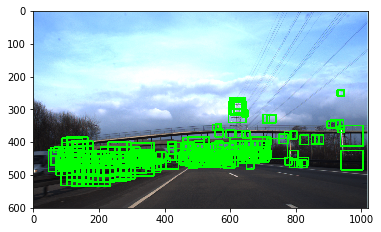

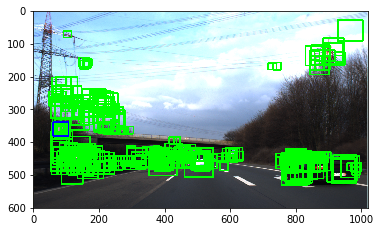

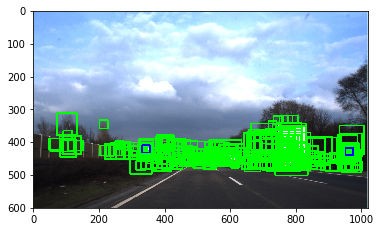

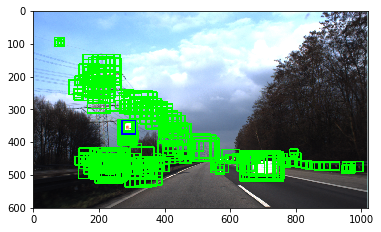

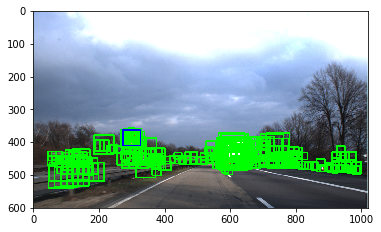

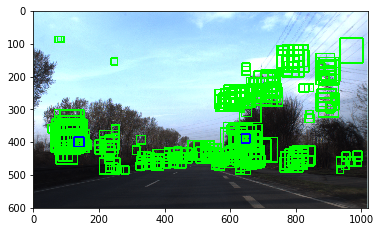

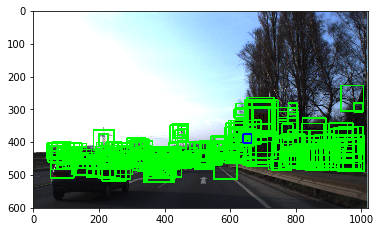

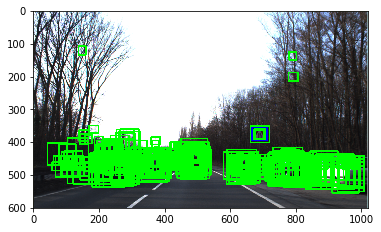

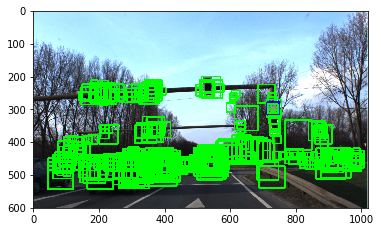

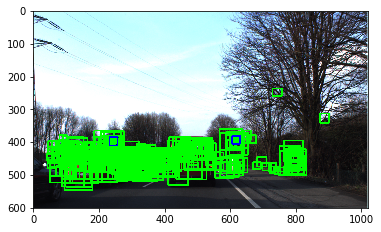

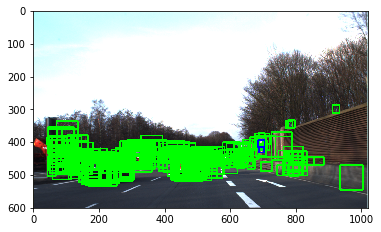

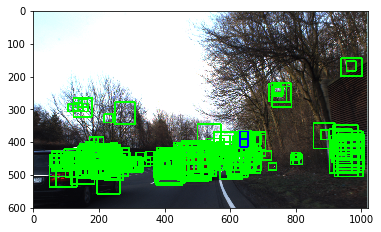

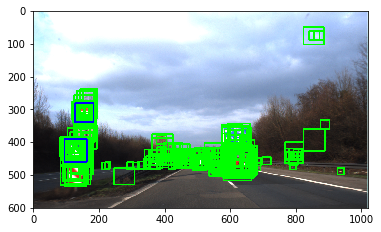

KeyboardInterrupt: 

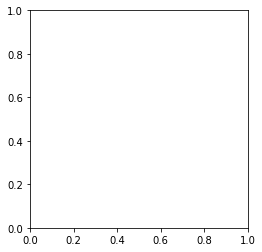

In [19]:
for filename in test_images:
    # Draw predictions
    aux = test_images.get(filename)[0].copy()
    for bbox in test_pred.get(filename)[0]:
        cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
    # Draw ground truth
    if filename in test_files:
        for idx in [i for i, x in enumerate(test_files) if x == filename]:
            bbox = test_bboxes[idx]
            cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()

### Evaluation using Mean Average Precision

git clone https://github.com/Cartucho/mAP.git

mkdir ground-truth

mkdir predicted

In [19]:
# for filename in test_images:
#     anns_ofs = open('mAP/input/ground-truth/' + filename[-9:-4:] + '.txt', 'w')
#     if filename in test_files:
#         for idx in [i for i, x in enumerate(test_files) if x == filename]:
#             bbox = test_bboxes[idx]
#             label = test_labels[idx]
#             anns_ofs.write(str(label) + ' ' + str(bbox[0]) + ' ' + str(bbox[1]) + ' ' + str(bbox[2]) + ' ' + str(bbox[3]) + '\n')
#     anns_ofs.close()

In [1]:
# %cd 

In [21]:
## We load our model
from keras.models import load_model
model_YesNo = load_model('Yes_No_Xception_1.h5')
model_Classification= load_model('Xception_model_0.h5')

In [22]:
color = [np.ndarray.tolist(np.random.choice(range(256), size=3)) for i in range(0,43)]

## Train (only to generate wrong examples for retraining)

In [32]:
data = np.genfromtxt("FullIJCNN2013/gt.txt", delimiter=';', dtype=str, usecols=range(0, 6))
filenames_data = ['FullIJCNN2013/' + data[i][0] for i in range(0,len(data))]
for num in range(0,600):
    filename = 'FullIJCNN2013' + '/' + "{:05d}".format(num) + '.ppm'
    img = cv2.imread(filename, cv2.IMREAD_COLOR)
    scale = IMG_HEIGHT / float(img.shape[0])
    if filename in filenames_data:
        for idx in [i for i, x in enumerate(filenames_data) if x == filename]:
            data[idx][1] = int(int(data[idx][1])*scale)
            data[idx][2] = int(int(data[idx][2])*scale)
            data[idx][3] = int(int(data[idx][3])*scale)
            data[idx][4] = int(int(data[idx][4])*scale)

In [33]:
start = time()

prds_ofs = open('Training_detection_results/Xception_0_09.txt', 'w')
for filename in train_images:

#     aux = train_images.get(filename)[0].copy()
    print(filename)
    for bbox in train_pred.get(filename)[0]:
        roi = train_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        roi_resized = cv2.resize(roi, SIGN_SIZE)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE[0],SIGN_SIZE[1],3])
     
        ########## Propio
        
        pred = model_YesNo.predict(roi_resized)
        sign_class = np.where(pred == np.max(pred))[1][0]
        confidence_max = np.max(pred)
        confidence_min = np.min(pred)
        # Run your own detector and save each traffic sign classification
        # ...
        # traffic_sign_class confidence bbox
        


        if (sign_class == 1):
            inter = 0
            if filename in filenames_data:
                for idx in [i for i, x in enumerate(filenames_data) if x == filename]:
                    bbox_true = np.asarray([int(data[idx][1]),int(data[idx][2]),int(data[idx][3]),int(data[idx][4])])
                    if intersection(bbox.reshape(1,4), bbox_true.reshape(1,4)) > 0:
                        inter = 1
                        break
                if inter == 0:
#                     cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
                    prds_ofs.write(str(filename) + ';' + \
                       str(bbox[0]) + ';' + \
                       str(bbox[1]) + ';' + \
                       str(bbox[2]) + ';' + \
                       str(bbox[3]) + '\n')
            else:
#                 cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (0,255,0), 3)
                prds_ofs.write(str(filename) + ';' + \
                   str(bbox[0]) + ';' + \
                   str(bbox[1]) + ';' + \
                   str(bbox[2]) + ';' + \
                   str(bbox[3]) + '\n')


#     plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
#     plt.show()
prds_ofs.close()
end = time()
print("Traffic sign detection took " + str(end - start) + " seconds")

FullIJCNN2013/00000.ppm
FullIJCNN2013/00001.ppm
FullIJCNN2013/00002.ppm
FullIJCNN2013/00003.ppm
FullIJCNN2013/00004.ppm
FullIJCNN2013/00005.ppm
FullIJCNN2013/00006.ppm
FullIJCNN2013/00007.ppm
FullIJCNN2013/00008.ppm
FullIJCNN2013/00009.ppm
FullIJCNN2013/00010.ppm
FullIJCNN2013/00011.ppm
FullIJCNN2013/00012.ppm
FullIJCNN2013/00013.ppm
FullIJCNN2013/00014.ppm
FullIJCNN2013/00015.ppm
FullIJCNN2013/00016.ppm
FullIJCNN2013/00017.ppm
FullIJCNN2013/00018.ppm
FullIJCNN2013/00019.ppm
FullIJCNN2013/00020.ppm
FullIJCNN2013/00021.ppm
FullIJCNN2013/00022.ppm
FullIJCNN2013/00023.ppm
FullIJCNN2013/00024.ppm
FullIJCNN2013/00025.ppm
FullIJCNN2013/00026.ppm
FullIJCNN2013/00027.ppm
FullIJCNN2013/00028.ppm
FullIJCNN2013/00029.ppm
FullIJCNN2013/00030.ppm
FullIJCNN2013/00031.ppm
FullIJCNN2013/00032.ppm
FullIJCNN2013/00033.ppm
FullIJCNN2013/00034.ppm
FullIJCNN2013/00035.ppm
FullIJCNN2013/00036.ppm
FullIJCNN2013/00037.ppm
FullIJCNN2013/00038.ppm
FullIJCNN2013/00039.ppm
FullIJCNN2013/00040.ppm
FullIJCNN2013/00

FullIJCNN2013/00342.ppm
FullIJCNN2013/00343.ppm
FullIJCNN2013/00344.ppm
FullIJCNN2013/00345.ppm
FullIJCNN2013/00346.ppm
FullIJCNN2013/00347.ppm
FullIJCNN2013/00348.ppm
FullIJCNN2013/00349.ppm
FullIJCNN2013/00350.ppm
FullIJCNN2013/00351.ppm
FullIJCNN2013/00352.ppm
FullIJCNN2013/00353.ppm
FullIJCNN2013/00354.ppm
FullIJCNN2013/00355.ppm
FullIJCNN2013/00356.ppm
FullIJCNN2013/00357.ppm
FullIJCNN2013/00358.ppm
FullIJCNN2013/00359.ppm
FullIJCNN2013/00360.ppm
FullIJCNN2013/00361.ppm
FullIJCNN2013/00362.ppm
FullIJCNN2013/00363.ppm
FullIJCNN2013/00364.ppm
FullIJCNN2013/00365.ppm
FullIJCNN2013/00366.ppm
FullIJCNN2013/00367.ppm
FullIJCNN2013/00368.ppm
FullIJCNN2013/00369.ppm
FullIJCNN2013/00370.ppm
FullIJCNN2013/00371.ppm
FullIJCNN2013/00372.ppm
FullIJCNN2013/00373.ppm
FullIJCNN2013/00374.ppm
FullIJCNN2013/00375.ppm
FullIJCNN2013/00376.ppm
FullIJCNN2013/00377.ppm
FullIJCNN2013/00378.ppm
FullIJCNN2013/00379.ppm
FullIJCNN2013/00380.ppm
FullIJCNN2013/00381.ppm
FullIJCNN2013/00382.ppm
FullIJCNN2013/00

## Test

In [ ]:
start = time()
for filename in test_images:
    prds_ofs = open('mAP/input/detection-results/' + filename[-9:-4:] + '.txt', 'w')
    aux = test_images.get(filename)[0].copy()
    print(filename)
    filename_found = []
    labels_found = []
    confidence_found = []
    bboxes_found = []
    for bbox in test_pred.get(filename)[0]:
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        roi_resized = cv2.resize(roi, SIGN_SIZE)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE[0],SIGN_SIZE[1],3])
        
        ########## Propio
        
        pred = model_YesNo.predict(roi_resized)
        sign_class = np.where(pred == np.max(pred))[1][0]
        confidence_max = np.max(pred)
        confidence_min = np.min(pred)
        # Run your own detector and save each traffic sign classification
        # ...
        # traffic_sign_class confidence bbox
        


        if (sign_class == 1 and confidence_max>0.7 and confidence_min<0.15):

            pred_2 = model_Classification.predict(roi_resized)
            sign_class_2 = np.where(pred_2 == np.max(pred_2))[1][0]

            confidence_max_2 = np.max(pred)
            confidence_second_max = -np.sort(-pred_2)[0][1]
            #Non maximum supression
            if (confidence_max_2>0.5):
                if sign_class_2 in labels_found:
                    added = 0
                    for j in [i for i,x in enumerate(labels_found) if x == sign_class_2]:
                        if intersection(bbox.reshape(1,4), bboxes_found[j].reshape(1,4))>0:
                            added = 1
                            if confidence_found[j]<confidence_max_2:
                                new_bbox = bbox
                                bboxes_found[j] = new_bbox
                                confidence_found[j] = max(confidence_max_2,confidence_found[j])
                    if added == 0:
                        print(confidence_max)
                        print(confidence_min)
                        print(sign_class_2)
                        print("--------")
                        labels_found.append(sign_class_2)
                        confidence_found.append(confidence_max_2)
                        bboxes_found.append(np.asarray(bbox))
                        filename_found.append(filename)
                else:
                    print(confidence_max)
                    print(confidence_min)
                    print(sign_class_2)
                    print("--------")
                    labels_found.append(sign_class_2)
                    confidence_found.append(confidence_max_2)
                    bboxes_found.append(np.asarray(bbox))
                    filename_found.append(filename)
    for i in range(0,len(labels_found)):
        cv2.rectangle(aux, (int(bboxes_found[i][0]),int(bboxes_found[i][1])),\
                           (int(bboxes_found[i][2]),int(bboxes_found[i][3])), color[labels_found[i]], 3)
        prds_ofs.write(str(labels_found[i]) + ' ' + \
                       str(confidence_found[i]) + ' ' + \
                       str(bboxes_found[i][0]) + ' ' + \
                       str(bboxes_found[i][1]) + ' ' + \
                       str(bboxes_found[i][2]) + ' ' + \
                       str(bboxes_found[i][3]) + '\n')
        if filename in test_files:
            for idx in [i for i, x in enumerate(test_files) if x == filename]:
                bbox = test_bboxes[idx]
                cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)

            
    prds_ofs.close()
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
end = time()
print("Traffic sign detection took " + str(end - start) + " seconds")

In [ ]:
start = time()
for filename in test_images:
    prds_ofs = open('mAP/input/detection-results/' + filename[-9:-4:] + '.txt', 'w')
    aux = test_images.get(filename)[0].copy()
    print(filename)
    filename_found = []
    labels_found = []
    confidence_found = []
    bboxes_found = []
    for bbox in test_pred.get(filename)[0]:
        roi = test_images.get(filename)[0][int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
        roi_resized = cv2.resize(roi, SIGN_SIZE)
        roi_resized = roi_resized.astype('float32')
        roi_resized /= 255.0
        roi_resized = np.reshape(roi_resized, [1,SIGN_SIZE[0],SIGN_SIZE[1],3])
        
        ########## Propio
        
        pred = model_YesNo.predict(roi_resized)
        sign_class = np.where(pred == np.max(pred))[1][0]
        confidence_max = np.max(pred)
        confidence_min = np.min(pred)
        # Run your own detector and save each traffic sign classification
        # ...
        # traffic_sign_class confidence bbox
        


        if (sign_class == 1 and confidence_max>0.7 and confidence_min<0.15):
            print(confidence_max)
            print(confidence_min)
            print("--------")
            pred_2 = model_Classification.predict(roi_resized)
            sign_class_2 = np.where(pred_2 == np.max(pred_2))[1][0]
            confidence_max_2 = np.max(pred)
            confidence_second_max = -np.sort(-pred_2)[0][1]
            if (confidence_max_2>0.5):
                if sign_class_2 in labels_found:
                    added = 0
                    for j in [i for i,x in enumerate(labels_found) if x == sign_class_2]:
                        if intersection(bbox.reshape(1,4), bboxes_found[j].reshape(1,4))>0:
                            added = 1
                            new_bbox = np.asarray([max(bbox[0], bboxes_found[j][0]),\
                                                   max(bbox[1], bboxes_found[j][1]),\
                                                   min(bbox[2], bboxes_found[j][2]),\
                                                   min(bbox[3], bboxes_found[j][3])])
                            bboxes_found[j] = new_bbox
                            confidence_found[j] = max(confidence_second_max,confidence_found[j])
                    if added == 0:
                        labels_found.append(sign_class_2)
                        confidence_found.append(confidence_max_2)
                        bboxes_found.append(np.asarray(bbox))
                        filename_found.append(filename)
                else:
                    labels_found.append(sign_class_2)
                    confidence_found.append(confidence_max_2)
                    bboxes_found.append(np.asarray(bbox))
                    filename_found.append(filename)
    for i in range(0,len(labels_found)):
        cv2.rectangle(aux, (int(bboxes_found[i][0]),int(bboxes_found[i][1])),\
                           (int(bboxes_found[i][2]),int(bboxes_found[i][3])), color[labels_found[i]], 3)
        prds_ofs.write(str(labels_found[i]) + ' ' + \
                       str(confidence_found[i]) + ' ' + \
                       str(bboxes_found[i][0]) + ' ' + \
                       str(bboxes_found[i][1]) + ' ' + \
                       str(bboxes_found[i][2]) + ' ' + \
                       str(bboxes_found[i][3]) + '\n')
        if filename in test_files:
            for idx in [i for i, x in enumerate(test_files) if x == filename]:
                bbox = test_bboxes[idx]
                cv2.rectangle(aux, (int(bbox[0]),int(bbox[1])), (int(bbox[2]),int(bbox[3])), (255,0,0), 3)

            
    prds_ofs.close()
    plt.imshow(cv2.cvtColor(aux, cv2.COLOR_BGR2RGB))
    plt.show()
end = time()
print("Traffic sign detection took " + str(end - start) + " seconds")

In [ ]:
# Sample results obtained using my detector
46.54% = 1 AP 
54.70% = 10 AP 
54.20% = 11 AP 
54.07% = 12 AP 
66.81% = 13 AP 
66.75% = 14 AP 
72.33% = 15 AP 
100.00% = 16 AP 
65.48% = 17 AP 
26.45% = 18 AP 
44.28% = 2 AP 
37.50% = 22 AP 
69.44% = 23 AP 
0.00% = 24 AP 
43.19% = 25 AP 
54.76% = 26 AP 
20.00% = 28 AP 
0.00% = 29 AP 
53.95% = 3 AP 
70.00% = 30 AP 
0.00% = 31 AP 
35.50% = 32 AP 
86.67% = 33 AP 
83.33% = 34 AP 
76.33% = 35 AP 
0.00% = 36 AP 
0.00% = 37 AP 
41.90% = 38 AP 
0.00% = 39 AP 
52.49% = 4 AP 
55.56% = 40 AP 
0.00% = 41 AP 
69.17% = 42 AP 
57.24% = 5 AP 
57.14% = 6 AP 
33.96% = 7 AP 
65.57% = 8 AP 
70.15% = 9 AP 
mAP = 46.99%
<Figure size 432x288 with 0 Axes>